# Cascading Randomization Demo on Inception V3

In this notebook, we will use the saliency python package to derive post-hoc saliency maps from inception_v3. 

This demo shows how to replicate the key experiment from the paper and also to compute the metrics used.

## Note
Note that the replication here uses a single image.

### Before running this notebook
Make sure you have all the installed the necessary packages from the requirements.txt file.


To run this notebooks, you will need inception pretrained weights. These are available from [tensorflow](http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz). Alternatively, the weights can be obtained and decompressed as follows:

```
wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz
```

In addition, make sure the files, 'imagenet_class_index.json' and 'inception_v3.ckpt' are in the models/inceptionsv3.

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import tensorflow as tf
import seaborn as sns
import saliency
import pickle
import PIL
import json

# urllib python2 v. python3 hack.
if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    from urllib import urlopen

import keras 
from matplotlib import gridspec
import seaborn as sns

from scipy.stats import spearmanr as spr
from scipy.stats import pearsonr
import pandas as pd
from skimage.measure import compare_ssim as ssim
from skimage import feature
slim=tf.contrib.slim

from src.inception_v3 import inception_v3_arg_scope
from src.inception_v3 import inception_v3

# some plotting defaults
%matplotlib inline
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

Using TensorFlow backend.
W1108 17:17:48.954725 140655769360128 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1108 17:17:48.956993 140655769360128 deprecation_wrapper.py:119] From ../src/inception_v3.py:39: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

def LoadImage(file_path, resize=True, sztple=(299, 299)):
    img = PIL.Image.open(file_path).convert('RGB')
    if resize:
        img = img.resize(sztple, PIL.Image.ANTIALIAS)
    img = np.asarray(img)
    return img / 127.5 - 1.0

def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    plt.imshow(im)
    plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [3]:
def get_saliency_constructors(model_graph,
                              model_session,
                              logit_tensor,
                              input_tensor,
                              gradcam=False,
                              conv_layer_gradcam=None):
    """Initialize mask functions in saliency package.

    Args:
        model_graph: tf graph of the model.
        model_session: tf session with trained model loaded.
        logit_tensor: tensor corresponding to the model logit output.
        input_tensor: tensor coresponding to the input data.
        gradcam: boolean to indicate whether to include gradcam.
        conv_layer_gradcam: tensor corresponding to activations
                            from a conv layer, from the trained model.
                            Authors recommend last layer.
    Returns:
        saliency_constructor: dictionary (name of method, and value is
                              function to each saliency method.
        neuron_selector: tensor of specific output to explain.
    """

    assert (type(tf.Graph()) == type(model_graph)),\
        ("Model graph should be of type {}".format(type(tf.Graph())))

    if gradcam and conv_layer_gradcam is None:
        raise ValueError("If gradcam is True, then conv_layer_gradcam"
                         "is be provided.")
    with model_graph.as_default():
        with tf.name_scope("saliency"):
            neuron_selector = tf.placeholder(tf.int32)
            y_salient = logit_tensor[neuron_selector]
    gradient_saliency = saliency.GradientSaliency(model_graph,
                                                  model_session,
                                                  y_salient,
                                                  input_tensor)
    guided_backprop = saliency.GuidedBackprop(model_graph,
                                              model_session,
                                              y_salient,
                                              input_tensor)
    integrated_gradients = saliency.IntegratedGradients(model_graph,
                                                        model_session,
                                                        y_salient,
                                                        input_tensor)
    saliency_constructor = {'vng': gradient_saliency,
                            'gbp': guided_backprop,
                            'ig': integrated_gradients}
    if gradcam:
        gradcam = saliency.GradCam(model_graph,
                                   model_session,
                                   y_salient,
                                   input_tensor,
                                   conv_layer_gradcam)
        saliency_constructor['gc'] = gradcam
    return saliency_constructor, neuron_selector

# Wrapper for Inception-v3 model

In [4]:
class Inceptionv3_Wrapper(object):
    def __init__(self, checkpointpath, labelmetadatapath):
        tf.reset_default_graph()
        self.graph = tf.Graph()
        self.chkpntpath = checkpointpath
        self.labelmetadatapath = labelmetadatapath
        self.num_classes = 1001 # 0 is background or null class
        self.label_dict = {}
        
        if not tf.io.gfile.exists(self.chkpntpath):
            raise ValueError("There is no checkpoint at the input path")
        with self.graph.as_default():
            self.input_batch = tf.placeholder(tf.float32,
                                          shape=(None, 299, 299, 3))
            with slim.arg_scope(inception_v3_arg_scope()):
                _, self.end_points = inception_v3(
                  self.input_batch,
                  is_training=False,
                  num_classes=self.num_classes)
                self.session = tf.Session(graph=self.graph)
                self.saver = tf.train.Saver()
                self.saver.restore(self.session, self.chkpntpath)
                
            self.logits = self.graph.get_tensor_by_name(
                'InceptionV3/Logits/SpatialSqueeze:0')
            self.trainable_variables = tf.trainable_variables()
        
        if not tf.io.gfile.exists(self.labelmetadatapath):
            raise ValueError("There is no label file at the input path.")
        
        # process labels in appropriate dictionary
        with open(self.labelmetadatapath) as json_file:
            data = json.load(json_file)
            shift = 0
            if self.num_classes == 1001:
                self.label_dict = {0: ["background", "background"]}
                shift = 1
            for key in data:
                self.label_dict[int(key)+shift] = data[key] 
        
    def predict(self, batch):
        if not isinstance(batch, (np.ndarray)):
            raise ValueError("input should be a numpy array!")
        
        if len(batch.shape) < 4:
            raise ValueError(
              "Shape should be (nsamples, height, width, channels)")
        
        feed_dict = {self.input_batch: batch}
        logits = self.session.run(self.logits,
                                  feed_dict = feed_dict)
        return logits
    
    def reinitlayerlist(self, blocklist, independent=False):
        """Reinitialize Tensors with these names."""
        if independent:
            self.__init__()
        tensors = []
        for op in self.trainable_variables:
            for blockname in blocklist:
                if blockname in op.name:
                    tensors.append(op)
                    
        # now reinitialize
        with self.graph.as_default():
            to_ini = tf.initialize_variables(tensors)
            _ = self.session.run(to_ini)
        return True
        
    def indextoclsnames(self, arr, topk=5):
        """Given a numpy vector, get label names for topk."""
        names = []
        topk_indices = arr.argsort()[::-1][:topk]
        for val in topk_indices:
            names.append(self.label_dict[val][1])
        return names

In [5]:
cwd = os.getcwd()
imagenetlabeljsonpath = '../models/inceptionv3/imagenet_class_index.json'
chkpntpath = '../models/inceptionv3/inception_v3.ckpt'
chkpntpath = os.path.join(cwd, chkpntpath)
imagenetlabeljsonpath = os.path.join(cwd, imagenetlabeljsonpath)
if not os.path.exists(chkpntpath):
    raise ValueError("Checkpoint path does not exist!")
if not os.path.exists(imagenetlabeljsonpath):
    raise ValueError("Label json path does not exist!")

# Load inception model and test predictions

In [6]:
inception_model = Inceptionv3_Wrapper(chkpntpath, imagenetlabeljsonpath)

W1108 17:17:49.023968 140655769360128 deprecation_wrapper.py:119] From ../src/inception_v3.py:528: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1108 17:17:55.738902 140655769360128 deprecation.py:323] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


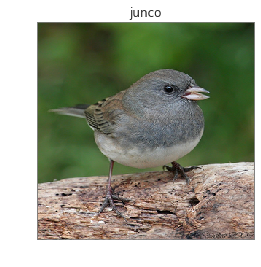

In [7]:
# Get bird image
birdimgpath = '../data/demo_images/ILSVRC2012_val_00015410.JPEG'
demo_batch = []
demo_batch.append(LoadImage(birdimgpath, resize=True))
demo_batch = np.array(demo_batch)

# model predictions for these images
logits = inception_model.predict(demo_batch)
for i in range(logits.shape[0]):
    title = inception_model.indextoclsnames(logits[i], topk=1)[0]
    ShowImage(demo_batch[i], title=title)

# Let's compute saliency maps for this image

In [8]:
# set up saliency computations.
saliency_dict, n_selector = get_saliency_constructors(inception_model.graph,
                                                      inception_model.session,
                                                      inception_model.logits[0],
                                                      inception_model.input_batch,
                                                      gradcam=True,
                                                      conv_layer_gradcam=inception_model.end_points['Mixed_7c'])

# these are the methods we will look at
saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                    'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                    'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                    'Integrated\nGradients': saliency_dict['ig'].GetMask,
                    'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                    'GradCAM': saliency_dict['gc'].GetMask}

# list of aggregate dictionary of masks.
# each image attribution will be a dictionary, where key=methods and value
# is the attribution numpy array. 
list_of_masks = []
for i, current_image in enumerate(demo_batch):
    print("On image {}".format(i))
    # zero baseline for integrated gradients
    baseline = np.zeros(current_image.shape)
    # prediction.
    imglogits = inception_model.session.run(
        [inception_model.logits],
        feed_dict={inception_model.input_batch: np.expand_dims(current_image, 0)})[0]
    
    prediction_class = imglogits.argmax() # compute saliency for top class.
    gen_feed_dict = {n_selector: prediction_class}
    
    # set up params for each saliency method
    saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                       'SmoothGrad': {"feed_dict": gen_feed_dict,
                                      "stdev_spread":0.15,
                                      "nsamples":50,
                                      "magnitude":False},
                       'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                       'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                 "x_steps":50,
                                                 "x_baseline":baseline},
                       'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                          "x_steps":50,
                                          "stdev_spread": 0.15,
                                          "x_baseline":baseline,
                                          "magnitude":False},
                       'GradCAM':{"feed_dict": gen_feed_dict,
                                  "three_dims": True}}    
    
    output_masks = {}
    for key in saliency_methods:
        print("On {}".format(key))
        params = saliency_params[key]
        output_masks[key] = saliency_methods[key](current_image,**params)
    # compute some other methods
    # input-gradient and guided-gradcam
    output_masks["Input-Grad"] = np.multiply(output_masks['Gradient'], current_image)
    output_masks["GBP-GC"] = np.multiply(output_masks['Guided\nBackProp'], output_masks['GradCAM'])
    list_of_masks.append(output_masks)

W1108 17:17:58.333840 140655769360128 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/guided_backprop.py:49: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W1108 17:17:59.906656 140655769360128 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/guided_backprop.py:56: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



On image 0
On Integrated
Gradients
On GradCAM


W1108 17:18:19.549656 140655769360128 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/grad_cam.py:77: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.



On Gradient
On Guided
BackProp
On IG
SmoothGrad
On SmoothGrad


In [9]:
# We are now doing normalization of the different attributions
# normalize by absolute values
list_of_masks_abs_norm = []

# normalize but keep the signs
list_of_masks_no_abs_norm = []
list_of_masks_0_1_norm = []

for i, img_dict in enumerate(list_of_masks):
    new_dict_abs_norm = {}
    new_dict_no_abs_norm = {}
    new_dict_0_1_norm = {}
    for key in img_dict:
        mask = img_dict[key]
        mask_abs_norm = abs_grayscale_norm(mask)
        mask_no_abs_norm = diverging_norm(mask)
        mask_0_1_norm = normalize_image(mask)
        new_dict_abs_norm[key] = mask_abs_norm
        new_dict_no_abs_norm[key] = mask_no_abs_norm
        new_dict_0_1_norm[key] =mask_0_1_norm
    list_of_masks_abs_norm.append(new_dict_abs_norm)
    list_of_masks_no_abs_norm.append(new_dict_no_abs_norm)
    list_of_masks_0_1_norm.append(new_dict_0_1_norm)

# Visualize Maps

In [10]:
# combine all the images to be plotted into one long list
# format is [(input, mask1, mask2, etc)]
mask_order = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
master_mask_list_abs_norm = []
master_mask_list_no_abs_norm = []
for i, (img_dict_abs_norm, img_dict_no_abs_norm) in enumerate(zip(list_of_masks_abs_norm,
                                                                  list_of_masks_no_abs_norm)):
    # first append original image
    og_img = demo_batch[i]
    master_mask_list_abs_norm.append(og_img)
    master_mask_list_no_abs_norm.append(og_img)
    
    # loop through dicts to append each mask type
    for mask_type in mask_order:
        master_mask_list_abs_norm.append(img_dict_abs_norm[mask_type])
        master_mask_list_no_abs_norm.append(img_dict_no_abs_norm[mask_type])

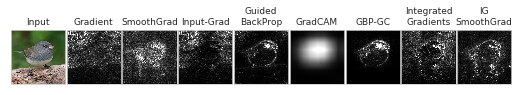

In [11]:
ncols = len(list_of_masks_abs_norm[i]) + 1
nrows = len(list_of_masks_abs_norm)

fig = plt.figure(figsize=(9,1))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='gray'
count = 0
titles = ["Input", "Gradient", "SmoothGrad", "Input-Grad",
          "Guided\nBackProp", "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%9==0):
            img = ((master_mask_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_abs_norm[count],
                      vmin=0.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count < 9:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

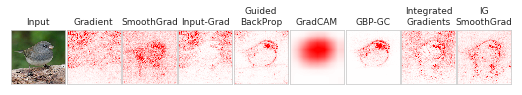

In [12]:
fig = plt.figure(figsize=(9,1))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='bwr'
count = 0
titles = ["Input", "Gradient", "SmoothGrad", "Input-Grad",
          "Guided\nBackProp", "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%9==0):
            img = ((master_mask_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_abs_norm[count],
                      vmin=-1.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count < 9:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

# Postive and Negative Relevance

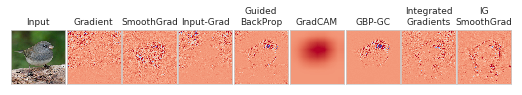

In [13]:
fig = plt.figure(figsize=(9,1))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='coolwarm'
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%9==0):
            img = ((master_mask_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_no_abs_norm[count],
                      vmin=-1.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
                # add labels
        if count < 9:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

# Now let's do cascading randomization

We will now perform a cascading randomization. We will reinitialize the all trainable parameters of the inception v3 model starting from the top layer and going all the way to the bottom layer.

Note, this is done here for just a single image. In the paper, we consider 200 for the rank correlation curves.

To see how we perform the randomization take a look at the reinitlayerlist method in the inceptionv3_wrapper class.

In [14]:
print(demo_batch.shape)
master_cascading_randomization_dictionary = {} # key will be layer name.
layer_randomization_order = ['InceptionV3/Logits', 'InceptionV3/Mixed_7c',
                             'InceptionV3/Mixed_7b', 'InceptionV3/Mixed_7a',
                             'InceptionV3/Mixed_6e', 'InceptionV3/Mixed_6d',
                             'InceptionV3/Mixed_6c', 'InceptionV3/Mixed_6b', 
                             'InceptionV3/Mixed_6a', 'InceptionV3/Mixed_5d',
                             'InceptionV3/Mixed_5c', 'InceptionV3/Mixed_5b',
                             'InceptionV3/Conv2d_4a_3x3', 'InceptionV3/Conv2d_3b_1x1',
                             'InceptionV3/Conv2d_2b_3x3', 'InceptionV3/Conv2d_2a_3x3',
                             'InceptionV3/Conv2d_1a_3x3']

(1, 299, 299, 3)


# This will take about 1hr 30mins w/out acceleration

In [15]:
# begin randomization
for i, layer_name in enumerate(layer_randomization_order):
    print("Cascading reinitialization up to on layer {}".format(layer_name))
    
    # list of parameters to be reintialized
    layer_list = layer_randomization_order[:i+1]
    
    # load a new inception v3 model.
    inception_model = Inceptionv3_Wrapper(chkpntpath, imagenetlabeljsonpath)
    
    # reinitialize all trainable ops up to that layer.
    inception_model.reinitlayerlist(layer_list)
    
    # set up saliency computations.
    saliency_dict, n_selector = get_saliency_constructors(inception_model.graph,
                                                          inception_model.session,
                                                          inception_model.logits[0],
                                                          inception_model.input_batch,
                                                          gradcam=True,
                                                          conv_layer_gradcam=inception_model.end_points['Mixed_7c'])

    # these are the methods we will look at
    saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                        'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                        'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                        'Integrated\nGradients': saliency_dict['ig'].GetMask,
                        'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                        'GradCAM': saliency_dict['gc'].GetMask}
    
    # list to store collection of images
    list_of_random_mask_per_layer = []
    for j, current_image in enumerate(demo_batch):
        # print(i)
        baseline = np.zeros(current_image.shape)
        imglogits = inception_model.session.run(
            [inception_model.logits],
            feed_dict={inception_model.input_batch: np.expand_dims(current_image, 0)})[0]
        
        prediction_class = imglogits.argmax() # this the output to explain.
        gen_feed_dict = {n_selector: prediction_class}

        # set up params for each saliency method
            # set up params for each saliency method
        saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                           'SmoothGrad': {"feed_dict": gen_feed_dict,
                                          "stdev_spread":0.15,
                                          "nsamples":50,
                                          "magnitude":False},
                           'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                           'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                     "x_steps":50,
                                                     "x_baseline":baseline},
                           'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                              "x_steps":50,
                                              "stdev_spread": 0.15,
                                              "x_baseline":baseline,
                                              "magnitude":False},
                           'GradCAM':{"feed_dict": gen_feed_dict,
                                      "three_dims": True}} 
        output_masks = {}
        for key in saliency_methods:
            # print("On {}".format(key))
            params = saliency_params[key]
            output_masks[key] = saliency_methods[key](current_image,**params)
        # compute some other methods
        # input-gradient and guided-gradcam
        output_masks["Input-Grad"] = np.multiply(output_masks['Gradient'], current_image)
        output_masks["GBP-GC"] = np.multiply(output_masks['Guided\nBackProp'], output_masks['GradCAM'])
        list_of_random_mask_per_layer.append(output_masks)
        # now add the list of random masks to the dictionary
    master_cascading_randomization_dictionary[layer_name] = list_of_random_mask_per_layer

Cascading reinitialization up to on layer InceptionV3/Logits


W1108 17:26:42.427312 140655769360128 deprecation.py:323] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Cascading reinitialization up to on layer InceptionV3/Mixed_7c
Cascading reinitialization up to on layer InceptionV3/Mixed_7b
Cascading reinitialization up to on layer InceptionV3/Mixed_7a
Cascading reinitialization up to on layer InceptionV3/Mixed_6e
Cascading reinitialization up to on layer InceptionV3/Mixed_6d
Cascading reinitialization up to on layer InceptionV3/Mixed_6c
Cascading reinitialization up to on layer InceptionV3/Mixed_6b
Cascading reinitialization up to on layer InceptionV3/Mixed_6a
Cascading reinitialization up to on layer InceptionV3/Mixed_5d
Cascading reinitialization up to on layer InceptionV3/Mixed_5c
Cascading reinitialization up to on layer InceptionV3/Mixed_5b
Cascading reinitialization up to on layer InceptionV3/Conv2d_4a_3x3
Cascading reinitialization up to on layer InceptionV3/Conv2d_3b_1x1
Cascading reinitialization up to on layer InceptionV3/Conv2d_2b_3x3
Cascading reinitialization up to on layer InceptionV3/Conv2d_2a_3x3
Cascading reinitialization up to on

In [16]:
master_cascading_randomization_dictionary_abs_norm = {}
master_cascading_randomization_dictionary_no_abs_norm = {}
master_cascading_randomization_dictionary_0_1_norm = {}

for layer in master_cascading_randomization_dictionary:
    mask_list_abs_norm = []
    mask_list_no_abs_norm = []
    mask_list_0_1_norm = []
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary[layer]):
    # first append original image
        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        new_dict_0_1_norm = {}
        for key in mask_dict:
            mask = mask_dict[key]
            
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            mask_0_1_norm = normalize_image(mask)
            
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
            new_dict_0_1_norm[key] = mask_0_1_norm
            
        mask_list_abs_norm.append(new_dict_abs_norm)
        mask_list_no_abs_norm.append(new_dict_no_abs_norm)
        mask_list_0_1_norm.append(new_dict_0_1_norm)
    master_cascading_randomization_dictionary_abs_norm[layer] = mask_list_abs_norm
    master_cascading_randomization_dictionary_no_abs_norm[layer] = mask_list_no_abs_norm
    master_cascading_randomization_dictionary_0_1_norm[layer] = mask_list_0_1_norm

In [17]:
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_no_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_no_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_0_1_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_0_1_norm[key][i])

# Visualizing Cascading Randomization

In [18]:
cascading_master_plotting_list_abs_norm = []
cascading_master_plotting_list_no_abs_norm = []

index_to_input_to_plot = 0 # this must be less than the len of demo_batch

mask_order = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
for method in mask_order:
    # first insert normal saliency method
    normal_mask_abs_norm = list_of_masks_abs_norm[index_to_input_to_plot][method]
    normal_mask_no_abs_norm = list_of_masks_no_abs_norm[index_to_input_to_plot][method]
    cascading_master_plotting_list_abs_norm.append(normal_mask_abs_norm)
    cascading_master_plotting_list_no_abs_norm.append(normal_mask_no_abs_norm)
    for layer in layer_randomization_order:
        mask_abs_norm =  master_cascading_randomization_dictionary_abs_norm[layer][index_to_input_to_plot][method]
        cascading_master_plotting_list_abs_norm.append(mask_abs_norm)
        
        mask_no_abs_norm =  master_cascading_randomization_dictionary_no_abs_norm[layer][index_to_input_to_plot][method]
        cascading_master_plotting_list_no_abs_norm.append(mask_no_abs_norm)

In [19]:
print(len(cascading_master_plotting_list_abs_norm))
print(len(cascading_master_plotting_list_no_abs_norm))

144
144


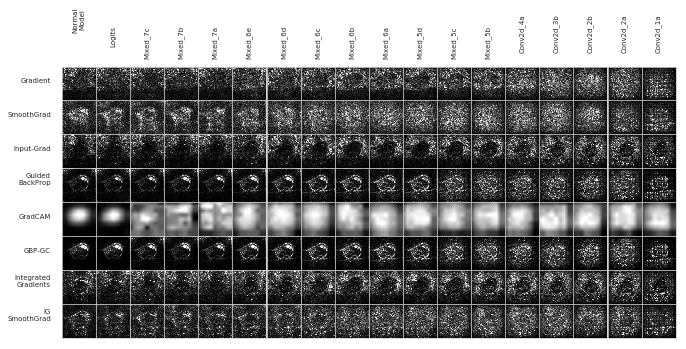

In [20]:
ncols = len(layer_randomization_order) + 1 # plus one for original mask
nrows = len(mask_order)

# converts normalized image into 0-255 range for
# plotting.
fig = plt.figure(figsize=(11,5))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='gray'
count = 0
titles = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
new_layer_names = ['Normal\nModel']
for val in layer_randomization_order:
    tl = val.split("/")[1]
    if len(tl)>8:
        tl = tl[:9]
    new_layer_names.append(tl)

for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(cascading_master_plotting_list_abs_norm[count],
                  vmin=0.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # add labels
        if count < 18:
            # adjust title(s)
            if len(new_layer_names[count])>8:
                pad_size=48
            else:
                pad_size=36
            ax.set_title(new_layer_names[count], fontsize=7, rotation=90,
                         pad=pad_size)

        # increment count
        count +=1

        if ax.is_first_col():
            ax.set_ylabel(titles[i], fontsize=7,rotation='horizontal', ha='right')
plt.show()

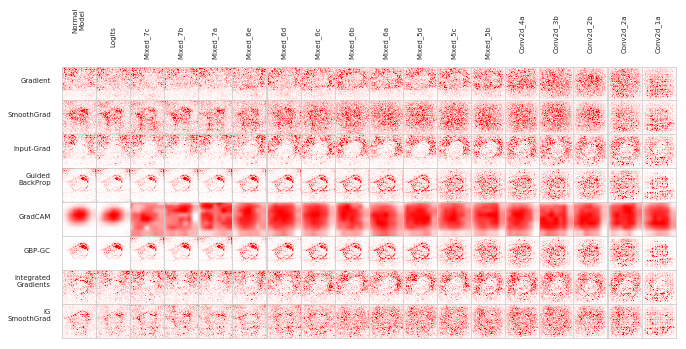

In [21]:
# converts normalized image into 0-255 range for
# plotting.
fig = plt.figure(figsize=(11,5))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='bwr'
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(cascading_master_plotting_list_abs_norm[count],
                  vmin=-1.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # add labels
        if count < 18:
            # adjust title(s)
            if len(new_layer_names[count])>8:
                pad_size=48
            else:
                pad_size=36
            ax.set_title(new_layer_names[count], fontsize=7, rotation=90,
                         pad=pad_size)

        # increment count
        count +=1

        if ax.is_first_col():
            ax.set_ylabel(titles[i], fontsize=7,rotation='horizontal', ha='right')
plt.show()

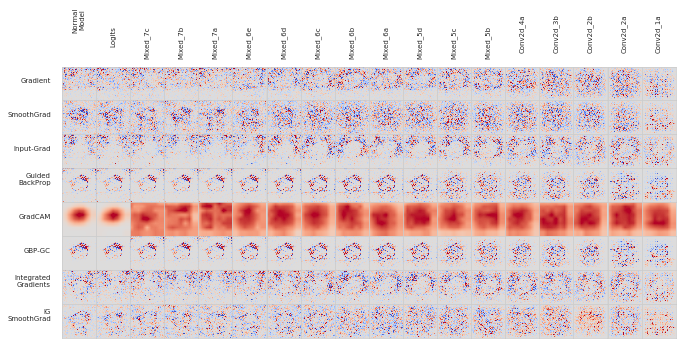

In [22]:
# converts normalized image into 0-255 range for
# plotting.
fig = plt.figure(figsize=(11,5))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='coolwarm'
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(cascading_master_plotting_list_no_abs_norm[count],
                  vmin=0.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # add labels
        if count < 18:
            # adjust title(s)
            if len(new_layer_names[count])>8:
                pad_size=48
            else:
                pad_size=36
            ax.set_title(new_layer_names[count], fontsize=7, rotation=90,
                         pad=pad_size)

        # increment count
        count +=1

        if ax.is_first_col():
            ax.set_ylabel(titles[i], fontsize=7,rotation='horizontal', ha='right')
plt.show()

# Positive and Negative Contribution Visualization

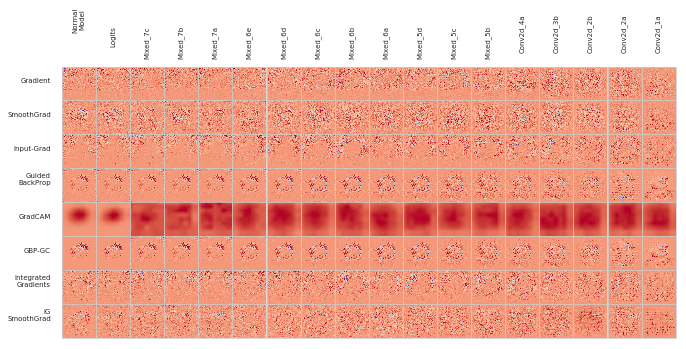

In [23]:
# converts normalized image into 0-255 range for
# plotting.
fig = plt.figure(figsize=(11,5))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='coolwarm'
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(cascading_master_plotting_list_no_abs_norm[count],
                  vmin=-1.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # add labels
        if count < 18:
            # adjust title(s)
            if len(new_layer_names[count])>8:
                pad_size=48
            else:
                pad_size=36
            ax.set_title(new_layer_names[count], fontsize=7, rotation=90,
                         pad=pad_size)

        # increment count
        count +=1

        if ax.is_first_col():
            ax.set_ylabel(titles[i], fontsize=7,rotation='horizontal', ha='right')
plt.show()

# Compute Similarity Metrics

Note that here, we will compute these metrics on a single image; however, in the paper, we use *200* images, whose image ids have been added to the data folder.

The code here is for illustration.

In [24]:
methods_list = list(master_cascading_randomization_dictionary_abs_norm['InceptionV3/Logits'][0].keys())

# dictionary to save all of the metrics.
rank_correlation_dictionary_abs_norm = {}
rank_correlation_dictionary_no_abs_norm = {}
ssim_dictionary_0_1_norm = {}
hog_dictionary_0_1_norm = {}

# initialize the dictionaries appropriately.
for layer in layer_randomization_order:
    rank_correlation_dictionary_abs_norm[layer] = {}
    rank_correlation_dictionary_no_abs_norm[layer] = {}
    ssim_dictionary_0_1_norm[layer] = {}
    hog_dictionary_0_1_norm[layer] = {}
    for method in methods_list:
        rank_correlation_dictionary_abs_norm[layer][method] = []
        rank_correlation_dictionary_no_abs_norm[layer][method] = []
        ssim_dictionary_0_1_norm[layer][method] = []
        hog_dictionary_0_1_norm[layer][method] = []
        
for layer in master_cascading_randomization_dictionary_abs_norm:
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary_abs_norm[layer]):
        for method in methods_list:
            normal_mask_abs_norm = list_of_masks_abs_norm[i][method]
            normal_mask_no_abs_norm = list_of_masks_no_abs_norm[i][method]
            normal_mask_0_1_norm = list_of_masks_0_1_norm[i][method]
            
            
            rand_mask_abs_norm = mask_dict[method]
            rand_mask_no_abs_norm = master_cascading_randomization_dictionary_no_abs_norm[layer][i][method]
            rand_mask_0_1_norm = master_cascading_randomization_dictionary_0_1_norm[layer][i][method]
            
            # compute rank correlation
            rk_abs_abs_value_norm, _ = spr(normal_mask_abs_norm.flatten(), rand_mask_abs_norm.flatten())
            rk_no_abs_value_norm, _ = spr(normal_mask_no_abs_norm.flatten(), rand_mask_no_abs_norm.flatten())
            
            # compute ssim
            ss1 = ssim(normal_mask_0_1_norm, rand_mask_0_1_norm,
                       gaussian_weights=True, multichannel=True)
            
            # rank correlation between histogram of gradients
            normal_hog = feature.hog(normal_mask_0_1_norm,
                                     pixels_per_cell=(16, 16))
            rand_hog = feature.hog(rand_mask_0_1_norm,
                                   pixels_per_cell=(16, 16))
            rank_corr_hog = spr(normal_hog, rand_hog)[0]
            
            # collate all the values into their respective dictionaries.
            rank_correlation_dictionary_abs_norm[layer][method].append(rk_abs_abs_value_norm)
            rank_correlation_dictionary_no_abs_norm[layer][method].append(rk_no_abs_value_norm)
            ssim_dictionary_0_1_norm[layer][method].append(ss1)
            hog_dictionary_0_1_norm[layer][method].append(rank_corr_hog)

In [25]:
rk_mean_dictionary = {}
rk_std_dictionary = {}

for key in rank_correlation_dictionary_abs_norm:
    rk_mean_dictionary[key] = {}
    rk_std_dictionary[key] = {}
    for key2 in rank_correlation_dictionary_abs_norm[key]:
        rk_mean_dictionary[key][key2] = np.mean(rank_correlation_dictionary_abs_norm[key][key2])
        rk_std_dictionary[key][key2] = np.std(rank_correlation_dictionary_abs_norm[key][key2])
        
rk_mean_dictionary_no_abs = {}
rk_std_dictionary_no_abs = {}

for key in rank_correlation_dictionary_no_abs_norm:
    rk_mean_dictionary_no_abs[key] = {}
    rk_std_dictionary_no_abs[key] = {}
    for key2 in rank_correlation_dictionary_no_abs_norm[key]:
        rk_mean_dictionary_no_abs[key][key2] = np.mean(rank_correlation_dictionary_no_abs_norm[key][key2])
        rk_std_dictionary_no_abs[key][key2] = np.std(rank_correlation_dictionary_no_abs_norm[key][key2])

In [26]:
ssim_mean_dictionary = {}
ssim_std_dictionary = {}

for key in ssim_dictionary_0_1_norm :
    ssim_mean_dictionary[key] = {}
    ssim_std_dictionary[key] = {}
    for key2 in ssim_dictionary_0_1_norm[key]:
        ssim_mean_dictionary[key][key2] = np.mean(ssim_dictionary_0_1_norm [key][key2])
        ssim_std_dictionary[key][key2] = np.std(ssim_dictionary_0_1_norm[key][key2])
        
hog_mean_dictionary = {}
hog_std_dictionary = {}

for key in hog_dictionary_0_1_norm:
    hog_mean_dictionary[key] = {}
    hog_std_dictionary[key] = {}
    for key2 in hog_dictionary_0_1_norm[key]:
        hog_mean_dictionary[key][key2] = np.mean(hog_dictionary_0_1_norm[key][key2])
        hog_std_dictionary[key][key2] = np.std(hog_dictionary_0_1_norm[key][key2])

In [27]:
rk_df = pd.DataFrame(rk_mean_dictionary)
rk_df2 = pd.DataFrame(rk_std_dictionary)

# include no randomization
rk_df["Original"] = [1.0]*rk_df.shape[0]
rk_df2["Original"] = [0.0]*rk_df2.shape[0]

# switch order of the columns
layer_order = ['Original']
for val in layer_randomization_order:
    layer_order.append(val)
to_reverse = False
if to_reverse:
    layer_order = list(reversed(layer_order))
rk_df = rk_df.reindex(columns=layer_order)
rk_df2 = rk_df2.reindex(columns=layer_order)

layer_randomization_order_plotting = ['Original', 'Logits', 'Mixed_7c',
                                     'Mixed_7b', 'Mixed_7a',
                                     'Mixed_6e', 'Mixed_6d',
                                     'Mixed_6c', 'Mixed_6b', 
                                     'Mixed_6a', 'Mixed_5d',
                                     'Mixed_5c', 'Mixed_5b',
                                     'Conv2d_4a_3x3', 'Conv2d_3b_1x1',
                                     'Conv2d_2b_3x3', 'Conv2d_2a_3x3',
                                     'Conv2d_1a_3x3']
new_layer_order = []
for val in layer_randomization_order_plotting:
    if len(val)>8:
        val = val[:9]
    new_layer_order.append(val)
    
rk_df.columns = new_layer_order
rk_df2.columns = new_layer_order

# Rank Correlation between positive only masks

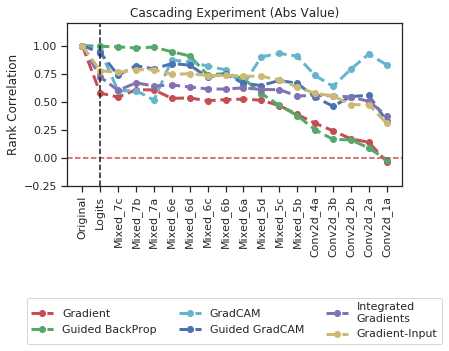

In [28]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(new_layer_order))]

plt.plot(x, rk_df.loc['Gradient', : ].values,
         'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x, rk_df.loc['Gradient', : ].values-rk_df2.loc['Gradient', : ].values,
                 rk_df.loc['Gradient', : ].values+rk_df2.loc['Gradient', : ].values,
                 facecolor='r', alpha=0.05)


plt.plot(x, rk_df.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x, rk_df.loc['Guided\nBackProp', : ].values-rk_df2.loc['Guided\nBackProp', : ].values,
                 rk_df.loc['Guided\nBackProp', : ].values+rk_df2.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.05)


plt.plot(x, rk_df.loc['GradCAM', : ].values, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x, rk_df.loc['GradCAM', : ].values-rk_df2.loc['GradCAM', : ].values,
                 rk_df.loc['GradCAM', : ].values+rk_df2.loc['GradCAM', : ].values,
                 facecolor='c', alpha=0.05)


plt.plot(x, rk_df.loc['GBP-GC', : ].values,
         'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x, rk_df.loc['GBP-GC', : ].values-rk_df2.loc['GBP-GC', : ].values,
                 rk_df.loc['GBP-GC', : ].values+rk_df2.loc['GBP-GC', : ].values,
                 facecolor='b', alpha=0.05)


plt.plot(x, rk_df.loc['Integrated\nGradients', : ].values,
         'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x, rk_df.loc['Integrated\nGradients', : ].values-rk_df2.loc['Integrated\nGradients', : ].values,
                 rk_df.loc['Integrated\nGradients', : ].values+rk_df2.loc['Integrated\nGradients', : ].values,
                 facecolor='m', alpha=0.05)

plt.plot(x, rk_df.loc['Input-Grad', : ].values,
         'yo-', lw=3, linestyle='--', label='Gradient-Input')
plt.fill_between(x, rk_df.loc['Input-Grad', : ].values-rk_df2.loc['Input-Grad', : ].values,
                 rk_df.loc['Input-Grad', : ].values+rk_df2.loc['Input-Grad', : ].values,
                 facecolor='y', alpha=0.05)

plt.xticks(x, new_layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.25, 1.2])
# plt.xlim([0.5, 4.5])
plt.ylabel("Rank Correlation")
plt.title("Cascading Experiment (Abs Value)")
# plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.show()

# Rank Correlation between signed masks

In [29]:
rk_df_no_abs = pd.DataFrame(rk_mean_dictionary_no_abs)
rk_df2_no_abs = pd.DataFrame(rk_std_dictionary_no_abs)

# include no randomization
rk_df_no_abs["Original"] = [1.0]*rk_df_no_abs.shape[0]
rk_df2_no_abs["Original"] = [0.0]*rk_df2_no_abs.shape[0]

# switch order of the columns
# switch order of the columns
layer_order=["Original"]
for val in layer_randomization_order:
    layer_order.append(val)
to_reverse = False # reverse the axis if desired
if to_reverse:
    layer_order = list(reversed(layer_order))
rk_df_no_abs = rk_df_no_abs.reindex(columns=layer_order)
rk_df2_no_abs = rk_df2_no_abs.reindex(columns=layer_order)

rk_df_no_abs.columns = new_layer_order
rk_df2_no_abs.columns = new_layer_order

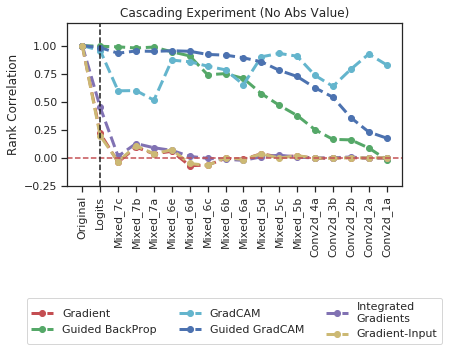

In [30]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(new_layer_order))]

plt.plot(x, rk_df_no_abs.loc['Gradient', : ].values,
         'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x, rk_df_no_abs.loc['Gradient', : ].values-rk_df2_no_abs.loc['Gradient', : ].values,
                 rk_df_no_abs.loc['Gradient', : ].values+rk_df2_no_abs.loc['Gradient', : ].values,
                 facecolor='r', alpha=0.05)


plt.plot(x, rk_df.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x, rk_df_no_abs.loc['Guided\nBackProp', : ].values-rk_df2_no_abs.loc['Guided\nBackProp', : ].values,
                 rk_df_no_abs.loc['Guided\nBackProp', : ].values+rk_df2_no_abs.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.05)


plt.plot(x, rk_df_no_abs.loc['GradCAM', : ].values, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x, rk_df_no_abs.loc['GradCAM', : ].values-rk_df2_no_abs.loc['GradCAM', : ].values,
                 rk_df_no_abs.loc['GradCAM', : ].values+rk_df2_no_abs.loc['GradCAM', : ].values,
                 facecolor='c', alpha=0.05)


plt.plot(x, rk_df_no_abs.loc['GBP-GC', : ].values,
         'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x, rk_df_no_abs.loc['GBP-GC', : ].values-rk_df2_no_abs.loc['GBP-GC', : ].values,
                 rk_df_no_abs.loc['GBP-GC', : ].values+rk_df2_no_abs.loc['GBP-GC', : ].values,
                 facecolor='b', alpha=0.05)


plt.plot(x, rk_df_no_abs.loc['Integrated\nGradients', : ].values,
         'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x, rk_df_no_abs.loc['Integrated\nGradients', : ].values-rk_df2_no_abs.loc['Integrated\nGradients', : ].values,
                 rk_df_no_abs.loc['Integrated\nGradients', : ].values+rk_df2_no_abs.loc['Integrated\nGradients', : ].values,
                 facecolor='m', alpha=0.05)

plt.plot(x, rk_df_no_abs.loc['Input-Grad', : ].values,
         'yo-', lw=3, linestyle='--', label='Gradient-Input')
plt.fill_between(x, rk_df_no_abs.loc['Input-Grad', : ].values-rk_df2_no_abs.loc['Input-Grad', : ].values,
                 rk_df_no_abs.loc['Input-Grad', : ].values+rk_df2_no_abs.loc['Input-Grad', : ].values,
                 facecolor='y', alpha=0.05)

plt.xticks(x, new_layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.25, 1.2])
# plt.xlim([0.5, 4.5])
plt.ylabel("Rank Correlation")
plt.title("Cascading Experiment (No Abs Value)")
# plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.show()

# SSIM Metric

In [31]:
ssim = pd.DataFrame(ssim_mean_dictionary)
ssim2 = pd.DataFrame(ssim_std_dictionary)

# include no randomization
ssim["Original"] = [1.0]*ssim.shape[0]
ssim2["Original"] = [0.0]*ssim2.shape[0]

# switch order of the columns
# switch order of the columns
layer_order=["Original"]
for val in layer_randomization_order:
    layer_order.append(val)
to_reverse = False # reverse the axis if desired
if to_reverse:
    layer_order = list(reversed(layer_order))
ssim = ssim.reindex(columns=layer_order)
ssim2 = ssim2.reindex(columns=layer_order)
    
ssim.columns = new_layer_order
ssim2.columns = new_layer_order

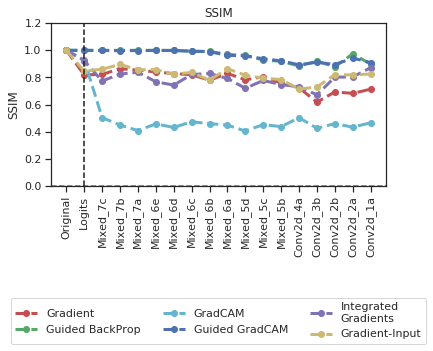

In [32]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(new_layer_order))]

plt.plot(x, ssim.loc['Gradient', : ].values,
         'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x, ssim.loc['Gradient', : ].values-ssim2.loc['Gradient', : ].values,
                 ssim.loc['Gradient', : ].values+ssim2.loc['Gradient', : ].values,
                 facecolor='r', alpha=0.05)


plt.plot(x, ssim.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x, ssim.loc['Guided\nBackProp', : ].values-ssim2.loc['Guided\nBackProp', : ].values,
                 ssim.loc['Guided\nBackProp', : ].values+ssim2.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.05)


plt.plot(x, ssim.loc['GradCAM', : ].values, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x, ssim.loc['GradCAM', : ].values-ssim2.loc['GradCAM', : ].values,
                 ssim.loc['GradCAM', : ].values+ssim2.loc['GradCAM', : ].values,
                 facecolor='c', alpha=0.05)


plt.plot(x, ssim.loc['GBP-GC', : ].values,
         'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x, ssim.loc['GBP-GC', : ].values-ssim2.loc['GBP-GC', : ].values,
                 ssim.loc['GBP-GC', : ].values+ssim2.loc['GBP-GC', : ].values,
                 facecolor='b', alpha=0.05)


plt.plot(x, ssim.loc['Integrated\nGradients', : ].values,
         'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x, ssim.loc['Integrated\nGradients', : ].values-ssim2.loc['Integrated\nGradients', : ].values,
                 ssim.loc['Integrated\nGradients', : ].values+ssim2.loc['Integrated\nGradients', : ].values,
                 facecolor='m', alpha=0.05)

plt.plot(x, ssim.loc['Input-Grad', : ].values,
         'yo-', lw=3, linestyle='--', label='Gradient-Input')
plt.fill_between(x, ssim.loc['Input-Grad', : ].values-ssim2.loc['Input-Grad', : ].values,
                 ssim.loc['Input-Grad', : ].values+ssim2.loc['Input-Grad', : ].values,
                 facecolor='y', alpha=0.05)

plt.xticks(x, new_layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([0.0, 1.2])
# plt.xlim([0.5, 4.5])
plt.ylabel("SSIM")
plt.title("SSIM")
# plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.show()

# Rank Correlation between Histogram of Gradients

In [33]:
rkhog = pd.DataFrame(hog_mean_dictionary)
rkhog2 = pd.DataFrame(hog_std_dictionary)

# include no randomization
rkhog["Original"] = [1.0]*rk_df.shape[0]
rkhog2["Original"] = [0.0]*rk_df2.shape[0]

# switch order of the columns
layer_order=["Original"]
for val in layer_randomization_order:
    layer_order.append(val)
to_reverse = False # reverse the axis if desired
if to_reverse:
    layer_order = list(reversed(layer_order))
rkhog = rkhog.reindex(columns=layer_order)
rkhog2 = rkhog2.reindex(columns=layer_order)
    
rkhog.columns = new_layer_order
rkhog2.columns = new_layer_order

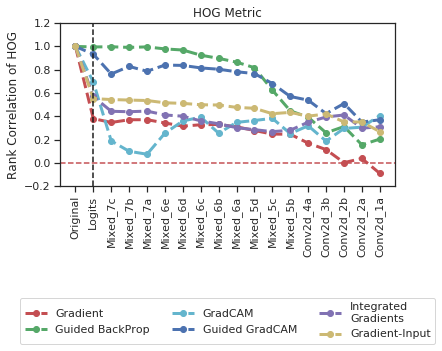

In [34]:
sns.set(style="ticks")
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(new_layer_order))]

plt.plot(x, rkhog.loc['Gradient', : ].values,
         'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x, rkhog.loc['Gradient', : ].values-rkhog2.loc['Gradient', : ].values,
                 rkhog.loc['Gradient', : ].values+rkhog2.loc['Gradient', : ].values,
                 facecolor='r', alpha=0.05)


plt.plot(x, rkhog.loc['Guided\nBackProp', : ].values,
         'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x, rkhog.loc['Guided\nBackProp', : ].values-rkhog2.loc['Guided\nBackProp', : ].values,
                 rkhog.loc['Guided\nBackProp', : ].values+rkhog2.loc['Guided\nBackProp', : ].values,
                 facecolor='g', alpha=0.05)


plt.plot(x, rkhog.loc['GradCAM', : ].values, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x, rkhog.loc['GradCAM', : ].values-rkhog2.loc['GradCAM', : ].values,
                 rkhog.loc['GradCAM', : ].values+rkhog2.loc['GradCAM', : ].values,
                 facecolor='c', alpha=0.05)


plt.plot(x, rkhog.loc['GBP-GC', : ].values,
         'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x, rkhog.loc['GBP-GC', : ].values-rkhog2.loc['GBP-GC', : ].values,
                 rkhog.loc['GBP-GC', : ].values+rkhog2.loc['GBP-GC', : ].values,
                 facecolor='b', alpha=0.05)


plt.plot(x, rkhog.loc['Integrated\nGradients', : ].values,
         'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x, rkhog.loc['Integrated\nGradients', : ].values-rkhog2.loc['Integrated\nGradients', : ].values,
                 rkhog.loc['Integrated\nGradients', : ].values+rkhog2.loc['Integrated\nGradients', : ].values,
                 facecolor='m', alpha=0.05)

plt.plot(x, rkhog.loc['Input-Grad', : ].values,
         'yo-', lw=3, linestyle='--', label='Gradient-Input')
plt.fill_between(x, rkhog.loc['Input-Grad', : ].values-rkhog2.loc['Input-Grad', : ].values,
                 rkhog.loc['Input-Grad', : ].values+rkhog2.loc['Input-Grad', : ].values,
                 facecolor='y', alpha=0.05)

plt.xticks(x, new_layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-.2, 1.2])
# plt.xlim([0.5, 4.5])
plt.ylabel("Rank Correlation of HOG")
plt.title("HOG Metric")
# plt.legend(loc=8, ncol=2, fontsize=7, frameon=False)
plt.tick_params(axis='x', which='both', top='off')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.show()